In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [3]:
dbuilder_path = None # change accordingly

import sys
sys.path.append(dbuilder_path)

from src import extract_uniprot     as uniprot
from src import extract_uniref      as uniref

MONGO_HOST = "10.1.0.202"
MONGO_PORT = 30077

uniprot_db = uniprot.uniprot_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT, name='UniProt')
uniprot_db_titles = uniprot.uniprot_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT, name='UniProt_updated_names')
uniref_db = uniref.uniref_extractor(mongo_host = MONGO_HOST, mongo_port = MONGO_PORT)

In [4]:
subgraphs_summary = pd.read_csv('data_generated_v2/AFDB90v4_subgraphs_summary.csv')
subgraphs_summary = subgraphs_summary.set_index('Subgraph')

AFDB90 = pd.read_csv('data_generated_v2/AFDB90v4_data_with_graph_labels.csv', index_col=0)

In [5]:
subgraphs_summary

,Avg_darkness,SD_darkness,N_members,TM,SP,Median_length,MAD_length,Median_darkness,MAD_darkness,N_communities
Subgraph,,,,,,,,,,
0,88.965221,22.034931,3036238,0.272574,0.272574,233.0,98.0,97.440,2.050,358579
1,88.189645,28.734713,1946,0.000000,0.000000,278.0,29.0,98.230,0.830,298
2,91.191058,11.996458,1871,2.030999,2.030999,493.0,49.0,95.000,2.020,301
3,83.702536,26.760281,1672,0.000000,0.000000,180.5,41.5,94.035,3.835,143
4,80.757456,26.934344,1490,0.000000,0.000000,139.0,7.0,94.160,3.705,213
...,...,...,...,...,...,...,...,...,...,...
147996,98.270000,1.390000,2,0.000000,0.000000,223.5,94.5,98.270,1.390,1
147995,0.000000,0.000000,2,0.000000,0.000000,184.0,0.0,0.000,0.000,1
147994,0.000000,0.000000,2,0.000000,0.000000,326.0,76.0,0.000,0.000,1


In [6]:
def map_ids_to_uniprot(ids, chunck_len = 100, mode='menzi', uniprot_db_titles=None):
    
    new_results = {'uniprot_acc': [], 'protein_name': [], 'name_source': [], 'name_type':[], 'taxonId': []}
    
    for i in range(0, len(ids), chunck_len):
        chunck = ids[i: i+chunck_len]
        
        if mode == 'menzi':
            uniprot_docs = uniprot_db_titles.col.find({'_id': {'$in': chunck}})
            for doc in uniprot_docs:
                new_results['uniprot_acc'].append(doc['_id'])
                new_results['protein_name'].append(doc['data']['NAME']['TITLE'])
                new_results['name_source'].append(doc['data']['NAME']['SOURCE'])
                new_results['name_type'].append(np.nan)
                new_results['taxonId'].append(np.nan)
            
        else:
            pass
        
    results = pd.DataFrame(new_results)

    return results

def map_ids_to_uniref(ids, chunck_len = 100, mode='menzi'):
    
    target_accs = [] 
    
    for i in range(0, len(ids), chunck_len):
        chunck = ids[i: i+chunck_len]
        
        if mode == 'menzi':
            uniref_docs = uniref_db.col.find({'_id': {'$in': chunck}})
            for doc in uniref_docs:
                target_accs += [i.split('_')[1] for i in doc['data']['UNIREF']['UniRef100']] 
            else:
                pass
        
    target_accs = list(set([i for i in target_accs if not i.startswith('UP')]))

    return target_accs

In [7]:
outfolder = 'data_generated_v2/uniprot_naming_assessment'

if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

collected_counts = {'Subgraph': [], 'No. entries': [], 'No. unique names': [], 
                    'Word diversity': [], 'Darkness class': [], 'Most freq. source': [], 'Source freq': [],
                    'No. targets': []}

for level in ['fully dark', 'fully bright', 'others']:
    
    print(level)
    
    if level == 'fully dark':
        target_galaxies = subgraphs_summary.loc[(subgraphs_summary.Avg_darkness <= 5)].sort_values(by='N_members', ascending=False)
    elif level == 'fully bright':
        target_galaxies = subgraphs_summary.loc[(subgraphs_summary.Avg_darkness >= 95)].sort_values(by='N_members', ascending=False)
    else:
        target_galaxies = subgraphs_summary.loc[(subgraphs_summary.Avg_darkness < 95) & (subgraphs_summary.Avg_darkness > 5)].sort_values(by='N_members', ascending=False)

    n = len(target_galaxies)
    count = 0
    target_accs = None
    for node_class in target_galaxies.index:
            
        count +=1

        outfile = '{}/AFDB90v4_subgraph_{}_uniprot_names_08022023.csv'.format(outfolder, node_class)

        if count %100 == 0:
            print(count,n, 'CURR NODE CLASS:', node_class)
        
        if not os.path.isfile(outfile):
            
            target_unirefs = list(AFDB90.loc[AFDB90.subgraphID == node_class].index)
            target_accs = map_ids_to_uniref(target_unirefs, chunck_len = 500, mode='menzi')
            
#             if count %100 == 0:
            print(count,n, 'CURR NODE CLASS:', node_class, '  ... {} total targets'.format(len(target_accs)))
            
            uniprot_data = map_ids_to_uniprot(target_accs, chunck_len=5000, mode='menzi', uniprot_db_titles=uniprot_db_titles)
            uniprot_data.to_csv(outfile, sep=',')

            if level != 'others':
                uniprot_docs = uniprot_db.col.find({'_id': {'$in': target_accs}})

                out_fasta = '{}/AFDB90v4_subgraph_{}_uniprot_names_08022023.fasta'.format(outfolder, node_class)
                with open(out_fasta, 'w') as outf:
                    for doc in uniprot_docs:
                        outf.write('>{}\n{}\n'.format(doc['_id'], doc['data']['SEQ']))
                
        else:
            uniprot_data = pd.read_csv(outfile, index_col=0)
            target_accs = uniprot_data.index

        words = []
        names = []
        for name in uniprot_data['protein_name']:
            name = str(name).lower()
            for to_mask in ['protein', 'domain', 'containing', 'superfamily', 'family']:
                name.replace(to_mask, '')

            name = name.replace('-',' ')
            words += name.split()

        tmp = uniprot_data['name_source'].value_counts(normalize =True).sort_values(ascending=False)

        collected_counts['Subgraph'].append(node_class)
        collected_counts['Darkness class'].append(level)
        collected_counts['No. entries'].append(len(uniprot_data))
        collected_counts['No. targets'].append(len(target_accs))
        collected_counts['No. unique names'].append(len(set(uniprot_data['protein_name'])))

        if len(words) == 0:
            collected_counts['Word diversity'].append(0)
            collected_counts['Most freq. source'].append(None)
            collected_counts['Source freq'].append(None)
        else:
            collected_counts['Word diversity'].append(len(set(words))/len(words))
            collected_counts['Most freq. source'].append(tmp.head(1).index[0])
            collected_counts['Source freq'].append(float(tmp.head(1)*100))

collected_counts = pd.DataFrame(collected_counts)
collected_counts = collected_counts.set_index('Subgraph')

collected_counts['Word diversity'] = collected_counts['Word diversity']*100
collected_counts['Name diversity'] = collected_counts['No. unique names']*100/collected_counts['No. entries']


fully dark
100 46318 CURR NODE CLASS: 1224
200 46318 CURR NODE CLASS: 2277
300 46318 CURR NODE CLASS: 3305
400 46318 CURR NODE CLASS: 4255
500 46318 CURR NODE CLASS: 4999
600 46318 CURR NODE CLASS: 5835
700 46318 CURR NODE CLASS: 6520
800 46318 CURR NODE CLASS: 7393
900 46318 CURR NODE CLASS: 8249
1000 46318 CURR NODE CLASS: 8906
1100 46318 CURR NODE CLASS: 9622
1200 46318 CURR NODE CLASS: 10494
1300 46318 CURR NODE CLASS: 11169
1400 46318 CURR NODE CLASS: 11770
1500 46318 CURR NODE CLASS: 12707
1600 46318 CURR NODE CLASS: 13907
1700 46318 CURR NODE CLASS: 14098
1800 46318 CURR NODE CLASS: 14539
1900 46318 CURR NODE CLASS: 15495
2000 46318 CURR NODE CLASS: 16247
2100 46318 CURR NODE CLASS: 17124
2200 46318 CURR NODE CLASS: 17558
2300 46318 CURR NODE CLASS: 18191
2400 46318 CURR NODE CLASS: 17254
2500 46318 CURR NODE CLASS: 20599
2600 46318 CURR NODE CLASS: 20125
2700 46318 CURR NODE CLASS: 20664
2800 46318 CURR NODE CLASS: 21446
2900 46318 CURR NODE CLASS: 19774
3000 46318 CURR NODE CL

23700 46318 CURR NODE CLASS: 130051
23800 46318 CURR NODE CLASS: 106125
23900 46318 CURR NODE CLASS: 106443
24000 46318 CURR NODE CLASS: 131387
24100 46318 CURR NODE CLASS: 129962
24200 46318 CURR NODE CLASS: 136795
24300 46318 CURR NODE CLASS: 139737
24400 46318 CURR NODE CLASS: 137921
24500 46318 CURR NODE CLASS: 136189
24600 46318 CURR NODE CLASS: 139650
24700 46318 CURR NODE CLASS: 138402
24800 46318 CURR NODE CLASS: 139231
24900 46318 CURR NODE CLASS: 140426
25000 46318 CURR NODE CLASS: 138908
25100 46318 CURR NODE CLASS: 144103
25200 46318 CURR NODE CLASS: 144760
25300 46318 CURR NODE CLASS: 141645
25400 46318 CURR NODE CLASS: 141518
25500 46318 CURR NODE CLASS: 141306
25600 46318 CURR NODE CLASS: 143633
25700 46318 CURR NODE CLASS: 137403
25800 46318 CURR NODE CLASS: 143055
25900 46318 CURR NODE CLASS: 143847
26000 46318 CURR NODE CLASS: 145981
26100 46318 CURR NODE CLASS: 145051
26200 46318 CURR NODE CLASS: 145744
26300 46318 CURR NODE CLASS: 146431
26400 46318 CURR NODE CLASS:

200 64787 CURR NODE CLASS: 696
300 64787 CURR NODE CLASS: 1044
400 64787 CURR NODE CLASS: 1385
500 64787 CURR NODE CLASS: 1835
600 64787 CURR NODE CLASS: 2250
700 64787 CURR NODE CLASS: 2714
800 64787 CURR NODE CLASS: 3156
900 64787 CURR NODE CLASS: 3558
1000 64787 CURR NODE CLASS: 4062
1100 64787 CURR NODE CLASS: 4544
1200 64787 CURR NODE CLASS: 5047
1300 64787 CURR NODE CLASS: 5426
1400 64787 CURR NODE CLASS: 5969
1500 64787 CURR NODE CLASS: 6408
1600 64787 CURR NODE CLASS: 6926
1700 64787 CURR NODE CLASS: 7390
1800 64787 CURR NODE CLASS: 7903
1900 64787 CURR NODE CLASS: 8301
2000 64787 CURR NODE CLASS: 8774
2100 64787 CURR NODE CLASS: 9295
2200 64787 CURR NODE CLASS: 9802
2300 64787 CURR NODE CLASS: 10098
2400 64787 CURR NODE CLASS: 10807
2500 64787 CURR NODE CLASS: 11231
2600 64787 CURR NODE CLASS: 11939
2700 64787 CURR NODE CLASS: 12221
2800 64787 CURR NODE CLASS: 12674
2900 64787 CURR NODE CLASS: 13177
3000 64787 CURR NODE CLASS: 13591
3100 64787 CURR NODE CLASS: 14162
3200 64787

24000 64787 CURR NODE CLASS: 95987
24100 64787 CURR NODE CLASS: 97970
24200 64787 CURR NODE CLASS: 98690
24300 64787 CURR NODE CLASS: 100189
24400 64787 CURR NODE CLASS: 98582
24500 64787 CURR NODE CLASS: 99345
24600 64787 CURR NODE CLASS: 99700
24700 64787 CURR NODE CLASS: 100098
24800 64787 CURR NODE CLASS: 100351
24900 64787 CURR NODE CLASS: 109216
25000 64787 CURR NODE CLASS: 107466
25100 64787 CURR NODE CLASS: 107260
25200 64787 CURR NODE CLASS: 106045
25300 64787 CURR NODE CLASS: 108465
25400 64787 CURR NODE CLASS: 108794
25500 64787 CURR NODE CLASS: 102506
25600 64787 CURR NODE CLASS: 100565
25700 64787 CURR NODE CLASS: 100969
25800 64787 CURR NODE CLASS: 101963
25900 64787 CURR NODE CLASS: 107790
26000 64787 CURR NODE CLASS: 102177
26100 64787 CURR NODE CLASS: 129808
26200 64787 CURR NODE CLASS: 131234
26300 64787 CURR NODE CLASS: 129954
26400 64787 CURR NODE CLASS: 127992
26500 64787 CURR NODE CLASS: 127951
26600 64787 CURR NODE CLASS: 131529
26700 64787 CURR NODE CLASS: 10692

46800 64787 CURR NODE CLASS: 173308
46900 64787 CURR NODE CLASS: 173529
47000 64787 CURR NODE CLASS: 178512
47100 64787 CURR NODE CLASS: 180208
47200 64787 CURR NODE CLASS: 179218
47300 64787 CURR NODE CLASS: 184621
47400 64787 CURR NODE CLASS: 184162
47500 64787 CURR NODE CLASS: 182987
47600 64787 CURR NODE CLASS: 183156
47700 64787 CURR NODE CLASS: 181551
47800 64787 CURR NODE CLASS: 184477
47900 64787 CURR NODE CLASS: 184463
48000 64787 CURR NODE CLASS: 231362
48100 64787 CURR NODE CLASS: 229573
48200 64787 CURR NODE CLASS: 230000
48300 64787 CURR NODE CLASS: 183533
48400 64787 CURR NODE CLASS: 230880
48500 64787 CURR NODE CLASS: 231059
48600 64787 CURR NODE CLASS: 189384
48700 64787 CURR NODE CLASS: 188608
48800 64787 CURR NODE CLASS: 188967
48900 64787 CURR NODE CLASS: 185708
49000 64787 CURR NODE CLASS: 185928
49100 64787 CURR NODE CLASS: 185861
49200 64787 CURR NODE CLASS: 182819
49300 64787 CURR NODE CLASS: 182609
49400 64787 CURR NODE CLASS: 180624
49500 64787 CURR NODE CLASS:

/scicore/home/schwede/soares0000/projects/dark_protein_universe/venv/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


100 131771 CURR NODE CLASS: 161
200 131771 CURR NODE CLASS: 317
300 131771 CURR NODE CLASS: 483
400 131771 CURR NODE CLASS: 630
500 131771 CURR NODE CLASS: 787
600 131771 CURR NODE CLASS: 943
700 131771 CURR NODE CLASS: 1097
800 131771 CURR NODE CLASS: 1260
900 131771 CURR NODE CLASS: 1418
1000 131771 CURR NODE CLASS: 1556
1100 131771 CURR NODE CLASS: 1708
1200 131771 CURR NODE CLASS: 1855
1300 131771 CURR NODE CLASS: 2019
1400 131771 CURR NODE CLASS: 2170
1500 131771 CURR NODE CLASS: 2309
1600 131771 CURR NODE CLASS: 2466
1700 131771 CURR NODE CLASS: 2632
1800 131771 CURR NODE CLASS: 2743
1900 131771 CURR NODE CLASS: 2897
2000 131771 CURR NODE CLASS: 3048
2100 131771 CURR NODE CLASS: 3190
2200 131771 CURR NODE CLASS: 3357
2300 131771 CURR NODE CLASS: 3507
2400 131771 CURR NODE CLASS: 3670
2500 131771 CURR NODE CLASS: 3783
2600 131771 CURR NODE CLASS: 3904
2700 131771 CURR NODE CLASS: 4045
2800 131771 CURR NODE CLASS: 4252
2900 131771 CURR NODE CLASS: 4370
3000 131771 CURR NODE CLASS: 

23400 131771 CURR NODE CLASS: 37266
23500 131771 CURR NODE CLASS: 37430
23600 131771 CURR NODE CLASS: 34244
23700 131771 CURR NODE CLASS: 37468
23800 131771 CURR NODE CLASS: 38242
23900 131771 CURR NODE CLASS: 37825
24000 131771 CURR NODE CLASS: 38176
24100 131771 CURR NODE CLASS: 38112
24200 131771 CURR NODE CLASS: 38508
24300 131771 CURR NODE CLASS: 38787
24400 131771 CURR NODE CLASS: 38955
24500 131771 CURR NODE CLASS: 39534
24600 131771 CURR NODE CLASS: 39272
24700 131771 CURR NODE CLASS: 39456
24800 131771 CURR NODE CLASS: 39316
24900 131771 CURR NODE CLASS: 39724
25000 131771 CURR NODE CLASS: 39675
25100 131771 CURR NODE CLASS: 40047
25200 131771 CURR NODE CLASS: 40232
25300 131771 CURR NODE CLASS: 40764
25400 131771 CURR NODE CLASS: 40688
25500 131771 CURR NODE CLASS: 40864
25600 131771 CURR NODE CLASS: 41454
25700 131771 CURR NODE CLASS: 40938
25800 131771 CURR NODE CLASS: 42949
25900 131771 CURR NODE CLASS: 41182
26000 131771 CURR NODE CLASS: 42054
26100 131771 CURR NODE CLASS

46200 131771 CURR NODE CLASS: 77223
46300 131771 CURR NODE CLASS: 77457
46400 131771 CURR NODE CLASS: 77724
46500 131771 CURR NODE CLASS: 77761
46600 131771 CURR NODE CLASS: 77988
46700 131771 CURR NODE CLASS: 77958
46800 131771 CURR NODE CLASS: 78310
46900 131771 CURR NODE CLASS: 78640
47000 131771 CURR NODE CLASS: 78812
47100 131771 CURR NODE CLASS: 78833
47200 131771 CURR NODE CLASS: 79086
47300 131771 CURR NODE CLASS: 78395
47400 131771 CURR NODE CLASS: 79370
47500 131771 CURR NODE CLASS: 79745
47600 131771 CURR NODE CLASS: 79882
47700 131771 CURR NODE CLASS: 79932
47800 131771 CURR NODE CLASS: 80166
47900 131771 CURR NODE CLASS: 80362
48000 131771 CURR NODE CLASS: 79647
48100 131771 CURR NODE CLASS: 81138
48200 131771 CURR NODE CLASS: 81280
48300 131771 CURR NODE CLASS: 82569
48400 131771 CURR NODE CLASS: 82615
48500 131771 CURR NODE CLASS: 81712
48600 131771 CURR NODE CLASS: 81770
48700 131771 CURR NODE CLASS: 80692
48800 131771 CURR NODE CLASS: 82274
48900 131771 CURR NODE CLASS

68700 131771 CURR NODE CLASS: 125276
68800 131771 CURR NODE CLASS: 125203
68900 131771 CURR NODE CLASS: 125152
69000 131771 CURR NODE CLASS: 125621
69100 131771 CURR NODE CLASS: 126130
69200 131771 CURR NODE CLASS: 125592
69300 131771 CURR NODE CLASS: 122241
69400 131771 CURR NODE CLASS: 121811
69500 131771 CURR NODE CLASS: 121724
69600 131771 CURR NODE CLASS: 121024
69700 131771 CURR NODE CLASS: 122258
69800 131771 CURR NODE CLASS: 122508
69900 131771 CURR NODE CLASS: 119429
70000 131771 CURR NODE CLASS: 118885
70100 131771 CURR NODE CLASS: 122048
70200 131771 CURR NODE CLASS: 122009
70300 131771 CURR NODE CLASS: 119386
70400 131771 CURR NODE CLASS: 124171
70500 131771 CURR NODE CLASS: 124119
70600 131771 CURR NODE CLASS: 124384
70700 131771 CURR NODE CLASS: 124493
70800 131771 CURR NODE CLASS: 124655
70900 131771 CURR NODE CLASS: 124538
71000 131771 CURR NODE CLASS: 218427
71100 131771 CURR NODE CLASS: 218932
71200 131771 CURR NODE CLASS: 218869
71300 131771 CURR NODE CLASS: 219216
7

100800 131771 CURR NODE CLASS: 188035
100900 131771 CURR NODE CLASS: 182129
101000 131771 CURR NODE CLASS: 188294
101100 131771 CURR NODE CLASS: 184157
101200 131771 CURR NODE CLASS: 184143
101300 131771 CURR NODE CLASS: 184079
101400 131771 CURR NODE CLASS: 184564
101500 131771 CURR NODE CLASS: 183218
101600 131771 CURR NODE CLASS: 184614
101700 131771 CURR NODE CLASS: 180666
101800 131771 CURR NODE CLASS: 181122
101900 131771 CURR NODE CLASS: 181048
102000 131771 CURR NODE CLASS: 181282
102100 131771 CURR NODE CLASS: 181720
102200 131771 CURR NODE CLASS: 181595
102300 131771 CURR NODE CLASS: 187102
102400 131771 CURR NODE CLASS: 186502
102500 131771 CURR NODE CLASS: 186989
102600 131771 CURR NODE CLASS: 185358
102700 131771 CURR NODE CLASS: 187059
102800 131771 CURR NODE CLASS: 174128
102900 131771 CURR NODE CLASS: 174871
103000 131771 CURR NODE CLASS: 173978
103100 131771 CURR NODE CLASS: 174745
103200 131771 CURR NODE CLASS: 186576
103300 131771 CURR NODE CLASS: 174536
103400 13177

122400 131771 CURR NODE CLASS: 221406
122500 131771 CURR NODE CLASS: 224376
122600 131771 CURR NODE CLASS: 221684
122700 131771 CURR NODE CLASS: 226488
122800 131771 CURR NODE CLASS: 226514
122900 131771 CURR NODE CLASS: 232525
123000 131771 CURR NODE CLASS: 226201
123100 131771 CURR NODE CLASS: 227298
123200 131771 CURR NODE CLASS: 226404
123300 131771 CURR NODE CLASS: 232152
123400 131771 CURR NODE CLASS: 233475
123500 131771 CURR NODE CLASS: 233677
123600 131771 CURR NODE CLASS: 232634
123700 131771 CURR NODE CLASS: 231822
123800 131771 CURR NODE CLASS: 232004
123900 131771 CURR NODE CLASS: 228878
124000 131771 CURR NODE CLASS: 225731
124100 131771 CURR NODE CLASS: 228558
124200 131771 CURR NODE CLASS: 229083
124300 131771 CURR NODE CLASS: 228437
124400 131771 CURR NODE CLASS: 225487
124500 131771 CURR NODE CLASS: 225640
124600 131771 CURR NODE CLASS: 227012
124700 131771 CURR NODE CLASS: 225980
124800 131771 CURR NODE CLASS: 226192
124900 131771 CURR NODE CLASS: 225290
125000 13177

In [8]:
collected_counts

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,No. targets,Name diversity
Subgraph,,,,,,,,
27,3485,81,1.084480,fully dark,Google,71.190818,3485,2.324247
133,1439,27,0.632002,fully dark,EMBL,71.994441,1439,1.876303
147,3496,34,0.303331,fully dark,EMBL,70.652174,3496,0.972540
156,1309,23,0.825959,fully dark,Google,54.698243,1309,1.757066
159,944,252,10.541132,fully dark,Google,93.855932,944,26.694915
...,...,...,...,...,...,...,...,...
239382,6,3,40.000000,others,EMBL,50.000000,6,50.000000
239381,6,3,45.000000,others,Google,100.000000,6,50.000000
239380,37,9,9.937888,others,EMBL,91.891892,37,24.324324


In [9]:
collected_counts.to_csv('data_generated_v2/AFDB90v4_uniprot_naming_assessment_counts.csv')

In [10]:
collected_counts = pd.read_csv('data_generated_v2/AFDB90v4_uniprot_naming_assessment_counts.csv', index_col=0)

The code above generates diversity scores for all components. But we are interested in comparing the scores of fully dark to fully bright corresponding to more than 50 uniprot acs only. So we select only those.

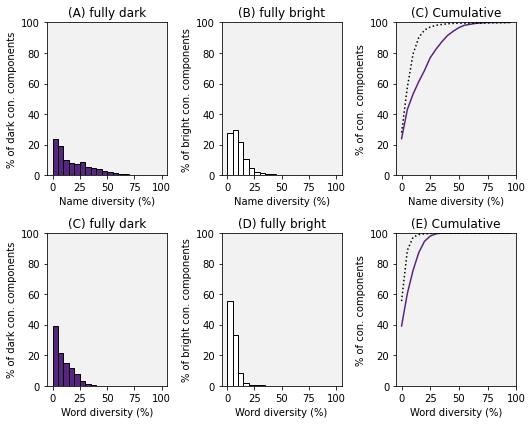

In [11]:
levels = ['Name diversity', 'Word diversity']
modes = ['fully dark', 'fully bright']
panel = ['A', 'B', 'C', 'D', 'E', 'F']

collected_counts = collected_counts.loc[collected_counts['No. entries'] >= 50]

fig, ax = plt.subplots(len(levels), len(modes)+1, figsize=(2.5*(len(modes)+1), 3*len(levels)))
percentage_dufs = []

count = 0
for i, level in enumerate(levels):
    cumulative = {i: [] for i in modes}
    
    for j, mode in enumerate(modes): 
        tmp = collected_counts.loc[(collected_counts['Darkness class'] == mode)]

        h,_ = np.histogram(tmp[level], bins=[i for i in range(0, 105, 5)])
        n_dark = h[0]
        h = h*100/sum(h)

        if mode == 'fully dark':
            colors = ['#57257F' for i in range(len(h))]
        else:
            colors = ['white' for i in range(len(h))]

        x = list(range(len(h)))
        y = list(h)

        ax[i][j].bar(x,y,1, align='edge', color=colors, edgecolor='k')
        ax[i][j].set_facecolor('#F2F2F2')
        ax[i][j].set_xticks(range(0,21,5))
        ax[i][j].set_xticklabels(range(0,101,25))
        ax[i][j].set_ylabel('% of {} con. components'.format(mode.split(' ')[1]))
        ax[i][j].set_xlabel('{} (%)'.format(level))

        ax[i][j].title.set_text('({}) {}'.format(panel[count], mode))

        ax[i][j].set_ylim(0,100)
        
        cumulative[mode] = np.cumsum(h)
        count += 1
    
    j += 1
    for mode in modes:
        if mode == 'fully dark':
            color = '#57257F'
            linestyle = '-'
        else:
            color = 'black'
            linestyle = ':'
        
        ax[i][j].plot(x, cumulative[mode], color=color, linestyle=linestyle)
        ax[i][j].set_facecolor('#F2F2F2')
        ax[i][j].set_xticks(range(0,21,5))
        ax[i][j].set_xticklabels(range(0,101,25))
        ax[i][j].set_ylabel('% of con. components')
        ax[i][j].set_xlabel('{} (%)'.format(level))

        ax[i][j].title.set_text('({}) Cumulative'.format(panel[count]))

        ax[i][j].set_ylim(0,100)
        
plt.tight_layout()
plt.savefig('plots/AFDBv4_uniref50_histogram_components_word_diversity.pdf')
plt.savefig('plots/AFDBv4_uniref50_histogram_components_word_diversity.png', dpi=2000)
    

In [12]:
collected_counts.groupby(['Darkness class'])['Word diversity'].agg([np.mean, np.std, np.median])

,mean,std,median
Darkness class,,,
fully bright,5.356837,4.227063,4.466501
fully dark,9.760665,8.063518,7.488987
others,6.078553,4.837414,4.838710


In [13]:
scipy.stats.kstest(collected_counts.loc[collected_counts['Darkness class'] == 'fully dark']['Word diversity'], collected_counts.loc[collected_counts['Darkness class'] == 'fully bright']['Word diversity'])

KstestResult(statistic=0.2915686231293117, pvalue=8.881784197001252e-16)

In [14]:
collected_counts.groupby(['Darkness class'])['Name diversity'].agg([np.mean, np.std, np.median])

,mean,std,median
Darkness class,,,
fully bright,10.426005,9.399631,8.595518
fully dark,18.757833,16.355234,13.013699
others,11.349392,9.551936,9.021082


In [15]:
collected_counts.loc[collected_counts['Darkness class'] == 'fully bright'].sort_values(by='Word diversity', ascending=False)

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,No. targets,Name diversity
Subgraph,,,,,,,,
100340,50,33,37.383178,fully bright,Reviewed,84.000000,50,66.000000
60703,74,70,36.244541,fully bright,Reviewed,63.513514,74,94.594595
39674,56,56,35.502959,fully bright,HAMAP-Rule,98.214286,56,100.000000
222476,57,57,35.087719,fully bright,HAMAP-Rule,98.245614,57,100.000000
59609,68,68,34.975369,fully bright,HAMAP-Rule,94.117647,68,100.000000
...,...,...,...,...,...,...,...,...
528,4729,9,0.074188,fully bright,HAMAP-Rule,93.000634,4729,0.190315
549,18469,43,0.064561,fully bright,EMBL,99.962099,18469,0.232823
807,14717,65,0.049301,fully bright,EMBL,75.769518,14717,0.441666


In [16]:
collected_counts.loc[collected_counts['Darkness class'] == 'fully dark'].sort_values(by='Word diversity', ascending=False)

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,No. targets,Name diversity
Subgraph,,,,,,,,
3314,54,43,45.355191,fully dark,Google,94.444444,54,79.629630
91789,54,30,40.935673,fully dark,Google,98.148148,54,55.555556
24120,62,46,38.356164,fully dark,Google,98.387097,62,74.193548
10980,55,32,38.121547,fully dark,Google,90.909091,55,58.181818
7299,61,44,38.034188,fully dark,Google,93.442623,61,72.131148
...,...,...,...,...,...,...,...,...
14963,610,3,0.383352,fully dark,Google,92.950820,610,0.491803
2107,997,8,0.303337,fully dark,EMBL,52.557673,997,0.802407
147,3496,34,0.303331,fully dark,EMBL,70.652174,3496,0.972540


In [17]:
selected_for_pfam = collected_counts.loc[(collected_counts['Darkness class'] == 'fully dark') & (collected_counts['Most freq. source'] == 'Google') & (collected_counts['Word diversity'] > 20)].sort_values(by='Word diversity', ascending=False)
selected_for_pfam

,No. entries,No. unique names,Word diversity,Darkness class,Most freq. source,Source freq,No. targets,Name diversity
Subgraph,,,,,,,,
3314,54,43,45.355191,fully dark,Google,94.444444,54,79.629630
91789,54,30,40.935673,fully dark,Google,98.148148,54,55.555556
24120,62,46,38.356164,fully dark,Google,98.387097,62,74.193548
10980,55,32,38.121547,fully dark,Google,90.909091,55,58.181818
7299,61,44,38.034188,fully dark,Google,93.442623,61,72.131148
...,...,...,...,...,...,...,...,...
29906,60,22,20.245399,fully dark,Google,100.000000,60,36.666667
80841,71,23,20.197044,fully dark,Google,95.774648,71,32.394366
6312,56,27,20.179372,fully dark,Google,100.000000,56,48.214286


In [18]:
import shutil

outfolder = 'data_generated_v2/uniprot_naming_assessment/selected_for_pfam'
if not os.path.isdir(outfolder):
    os.mkdir(outfolder)

In [19]:
targets = []
for subgraph in selected_for_pfam.index:
    
    curr_fasta = 'data_generated_v2/uniprot_naming_assessment/AFDB90v4_subgraph_{}_uniprot_names_08022023.fasta'.format(subgraph)
    curr_csv   = 'data_generated_v2/uniprot_naming_assessment/AFDB90v4_subgraph_{}_uniprot_names_08022023.csv'.format(subgraph)
    
    final_fasta = '{}/{}'.format(outfolder, curr_fasta.split('/')[-1]).replace('AFDB90v4_subgraph', 'Component')
    final_csv   = '{}/{}'.format(outfolder, curr_csv.split('/')[-1]).replace('AFDB90v4_subgraph', 'Component')
    
    if not os.path.isfile(final_fasta):
        print(final_fasta)
        targets.append(subgraph)
    
        shutil.copyfile(curr_fasta, final_fasta)
        shutil.copyfile(curr_csv, final_csv)
